In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd()) # dosya yolunu ver
%run ../Model.ipynb
%run ../Dataset.ipynb

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/arf/home/tunal/ondemand/PhD Thesis Starting/01_SON/Tik-4/Tez/01-Moon/02-UAE_for_Moon


In [2]:
# Custom Transform
class NoiseTransform:
    """Add some noise."""

    def __init__(self, split_ratio=0.001, dim=2):

        self.normal_dist = split_ratio*np.random.randn(dim,)
        
    def __call__(self, x):
      return x + self.normal_dist

In [3]:
# Hyper-Parameters & Settings

dataset_size = 1000
batch_size = 500
lr = 0.003

epochs = 1000
max_patience = 1000

split_ratio = 0.001

In [4]:
# Dataset
train_dataset = MoonDataset(mode='train', n_samples=dataset_size, transform=NoiseTransform(split_ratio))
val_dataset = MoonDataset(mode='val', n_samples=dataset_size, transform=NoiseTransform(split_ratio))
test_dataset = MoonDataset(mode='test', n_samples=dataset_size)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

# Evaluation

In [ ]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("results", exist_ok=True)

name = 'results/UAE_Moon'
model_eval = torch.load(name + '.model', weights_only=False)
model_eval.eval()

# MSE on Test Set

In [10]:
X_test, y_test = next(iter(test_loader))

# Test verisini modele ver
with torch.no_grad():
    z, x_hat = model_eval(X_test)   # X_test[:] yazman ile aynı

# MSE Loss nesnesi
mse_loss = nn.MSELoss()

# Ortalama MSE hesapla
mse = mse_loss(x_hat, X_test)

print("Test MSE:", mse.item())

# results klasörünü oluştur
os.makedirs("results", exist_ok=True)

# Dosyaya yaz
file_path = "results/test_mse.txt"
with open(file_path, "w") as f:
    f.write(f"Test MSE: {mse.item()}\n")

print(f"Test MSE results/ klasörüne kaydedildi: {file_path}")

Test MSE: 0.0003405121387913823
Test MSE results/ klasörüne kaydedildi: results/test_mse.txt


In [6]:
from torchsummary import summary
summary(model_eval, input_size=(2,))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       192
|    └─SiLU: 2-2                         --
|    └─BatchNorm1d: 2-3                  128
|    └─Linear: 2-4                       4,160
|    └─SiLU: 2-5                         --
|    └─BatchNorm1d: 2-6                  128
|    └─Linear: 2-7                       4,160
|    └─SiLU: 2-8                         --
|    └─BatchNorm1d: 2-9                  128
|    └─Linear: 2-10                      65
|    └─Sigmoid: 2-11                     --
├─Sequential: 1-2                        --
|    └─Linear: 2-12                      128
|    └─SiLU: 2-13                        --
|    └─Linear: 2-14                      4,160
|    └─SiLU: 2-15                        --
|    └─Linear: 2-16                      4,160
|    └─SiLU: 2-17                        --
|    └─Linear: 2-18                      130
|    └─Sigmoid: 2-19                     --
Total par

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       192
|    └─SiLU: 2-2                         --
|    └─BatchNorm1d: 2-3                  128
|    └─Linear: 2-4                       4,160
|    └─SiLU: 2-5                         --
|    └─BatchNorm1d: 2-6                  128
|    └─Linear: 2-7                       4,160
|    └─SiLU: 2-8                         --
|    └─BatchNorm1d: 2-9                  128
|    └─Linear: 2-10                      65
|    └─Sigmoid: 2-11                     --
├─Sequential: 1-2                        --
|    └─Linear: 2-12                      128
|    └─SiLU: 2-13                        --
|    └─Linear: 2-14                      4,160
|    └─SiLU: 2-15                        --
|    └─Linear: 2-16                      4,160
|    └─SiLU: 2-17                        --
|    └─Linear: 2-18                      130
|    └─Sigmoid: 2-19                     --
Total par

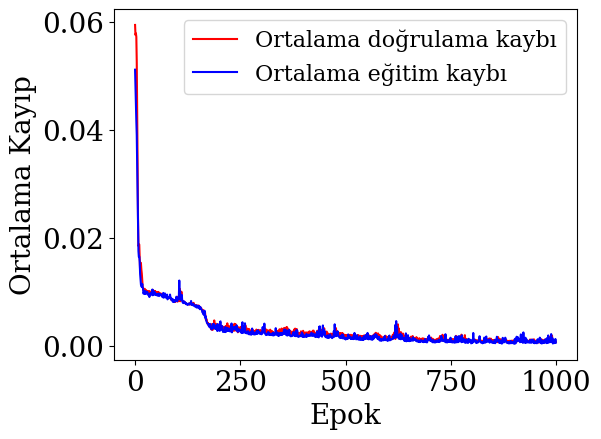

In [6]:
# Kayıpları yükle
losses = np.loadtxt("results/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Grafik oluştur
plt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")
plt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")

plt.xlabel("Epok")
plt.ylabel("Ortalama Kayıp")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("results/average_losses_per_epoch.pdf")
plt.show()

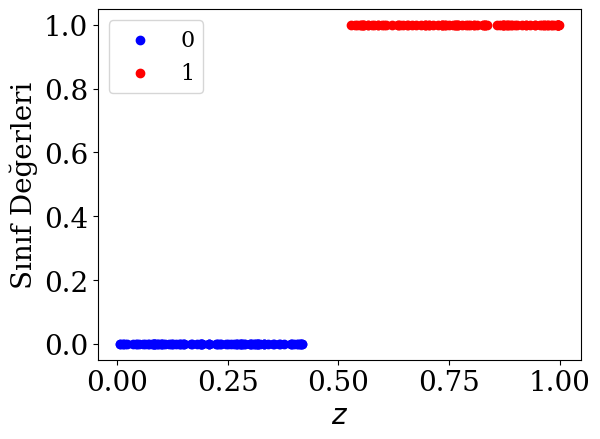

In [7]:
X_test, y_test = next(iter(test_loader))

z, x_hat = model_eval(X_test[:])

# Sınıf 0
plt.scatter(z.detach().numpy()[y_test.detach().numpy()==0],
            y_test.detach().numpy()[y_test.detach().numpy()==0],
            color='blue', label='0', alpha=1)

# Sınıf 1
plt.scatter(z.detach().numpy()[y_test.detach().numpy()==1],
            y_test.detach().numpy()[y_test.detach().numpy()==1],
            color='red', label='1', alpha=1)

# Legend (açıklama kutusu)
plt.legend(loc='upper left')
plt.ylabel('Sınıf Değerleri')
plt.xlabel('$z$')
plt.legend(loc='upper left', fontsize=16)

plt.tight_layout()
plt.savefig("results/moon_test_data_latent.pdf")
plt.show()

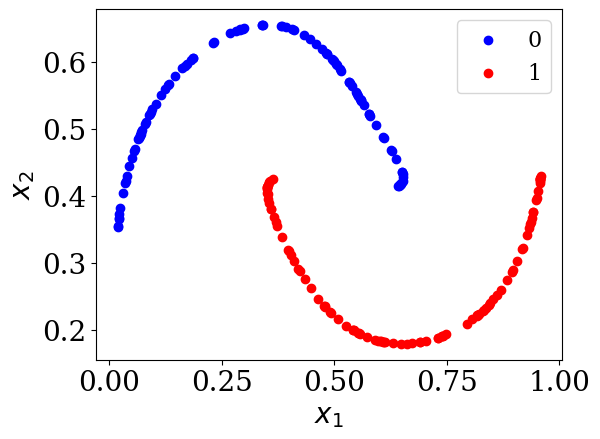

In [8]:
# Sınıf 0
plt.scatter(x_hat.detach().numpy()[y_test==0, 0],
            x_hat.detach().numpy()[y_test==0, 1], color='blue', label='0', alpha=1)

# Sınıf 1
plt.scatter(x_hat.detach().numpy()[y_test==1, 0],
            x_hat.detach().numpy()[y_test==1, 1], color='red', label='1', alpha=1)

# Legend (açıklama kutusu)
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')

plt.tight_layout()
plt.savefig("results/moon_test_data_prod.pdf")
plt.show()

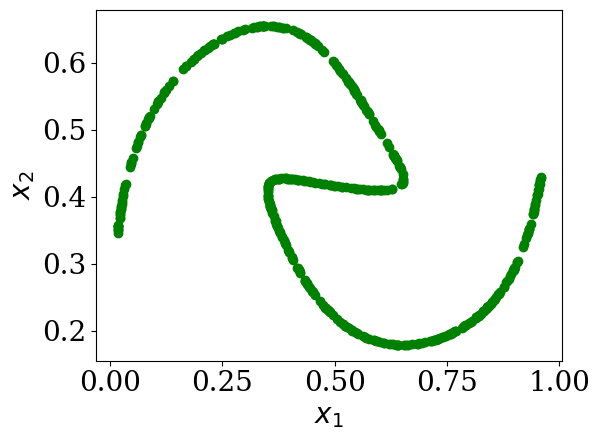

In [9]:
uniform_dist = torch.distributions.uniform.Uniform(low= torch.zeros((1,)), high=torch.ones((1,)))
new_data = model_eval.decoder(uniform_dist.sample((500,)))

plt.scatter(new_data[:,0].cpu().detach().numpy(), new_data[:,1].cpu().detach().numpy(), c='green', alpha=1)


plt.ylabel('$x_2$')
plt.xlabel('$x_1$')

plt.tight_layout()
plt.savefig("results/uniform_to_moon.pdf")
plt.show()